# Differentiating voltage data

Differential Voltage Analysis (DVA) and Incremental Capacity Analysis are popular
methods of characterising the degradation state of a cell. PyProBE offers multiple
methods to the user which will be explored in this example.

First import the package and dataset:

In [1]:
%%capture
%pip install matplotlib

In [2]:
import pyprobe
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
info_dictionary = {
    "Name": "Sample cell",
    "Chemistry": "NMC622",
    "Nominal Capacity [Ah]": 0.04,
    "Cycler number": 1,
    "Channel number": 1,
}
data_directory = "../../../tests/sample_data/neware"

# Create a cell object
cell = pyprobe.Cell(info=info_dictionary)
cell.add_procedure(
    procedure_name="Sample",
    folder_path=data_directory,
    filename="sample_data_neware.parquet",
)

The break-in cycles of this dataset are at C/10, so can be analysed as pseudo-OCV curves. We're going to look at the last cycle:

<Axes: xlabel='Time [hr]'>

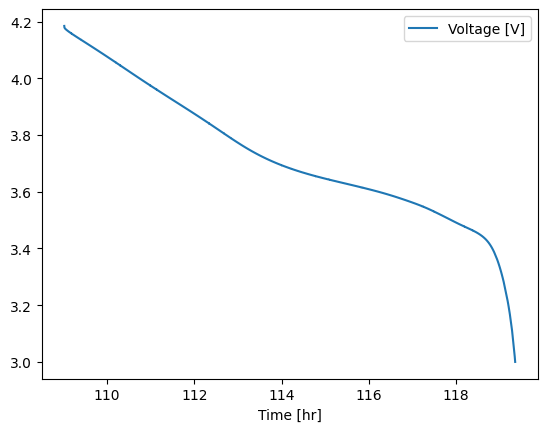

In [4]:
final_cycle = cell.procedure["Sample"].experiment("Break-in Cycles").cycle(-1)

final_cycle.discharge(0).plot(x="Time [hr]", y="Voltage [V]")

We're going to look at using the finite-difference based differentiation method, first 
on the raw data:

['Capacity [Ah]', 'Voltage [V]', 'd(Voltage [V])/d(Capacity [Ah])']


<Axes: xlabel='Capacity [Ah]'>

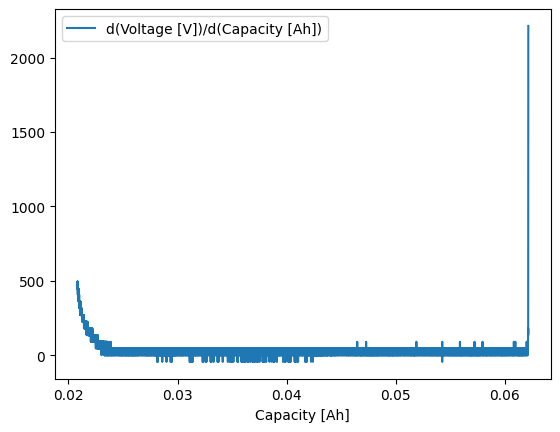

In [5]:
from pyprobe.analysis import differentiation

raw_data_dVdQ = differentiation.gradient(
    final_cycle.discharge(0), "Capacity [Ah]", "Voltage [V]"
)
print(raw_data_dVdQ.column_list)
raw_data_dVdQ.plot(x="Capacity [Ah]", y="d(Voltage [V])/d(Capacity [Ah])")

This gives a clearly poor result. This is due to the noise in the experimental data.
We can apply a smoothing function to the voltage prior to differentiating to remove this
noise:

<Axes: xlabel='Capacity [Ah]'>

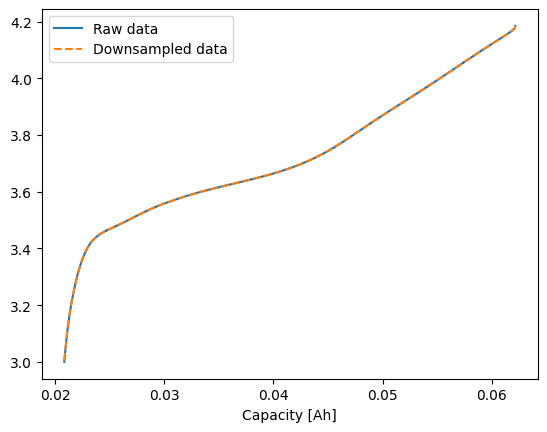

In [6]:
from pyprobe.analysis import smoothing


downsampled_data = smoothing.downsample(
    input_data=final_cycle.discharge(0),
    target_column="Voltage [V]",
    sampling_interval=0.002,
)
fig, ax = plt.subplots()
final_cycle.discharge(0).plot(
    x="Capacity [Ah]", y="Voltage [V]", ax=ax, label="Raw data"
)
downsampled_data.plot(
    x="Capacity [Ah]", y="Voltage [V]", ax=ax, style="--", label="Downsampled data"
)

We can now differentiate the smoothed data object:

Text(0, 0.5, 'd(Capacity [Ah])/d(Voltage [V])')

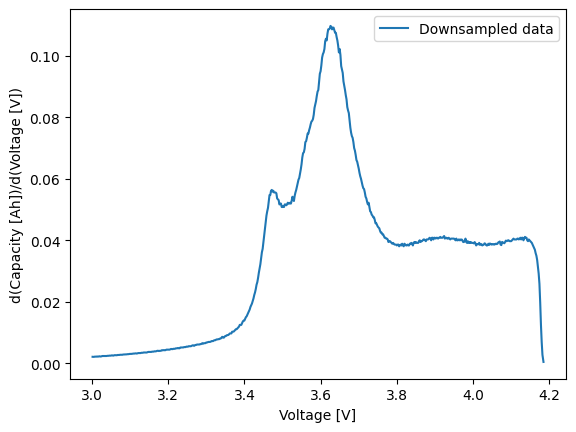

In [7]:
downsampled_data_dVdQ = differentiation.gradient(
    downsampled_data, "Voltage [V]", "Capacity [Ah]"
)

fig, ax = plt.subplots()
downsampled_data_dVdQ.plot(
    x="Voltage [V]",
    y="d(Capacity [Ah])/d(Voltage [V])",
    ax=ax,
    label="Downsampled data",
)
ax.set_ylabel("d(Capacity [Ah])/d(Voltage [V])")

PyProBE has multiple smoothing methods, so you can easily compare their effect on the ICA result:

Text(0, 0.5, 'd(Capacity [Ah])/d(Voltage [V])')

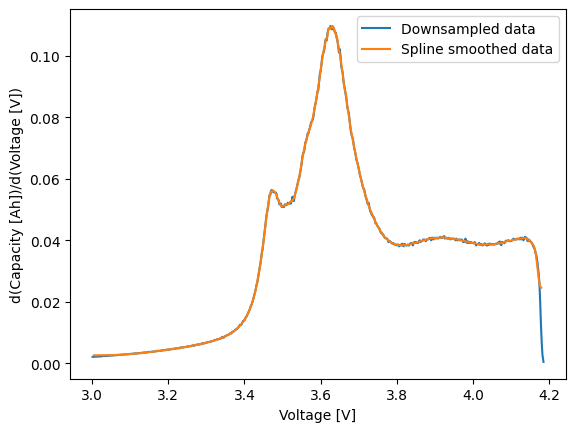

In [8]:
spline_smoothed_data = smoothing.spline_smoothing(
    input_data=final_cycle.discharge(0),
    x="Capacity [Ah]",
    target_column="Voltage [V]",
    smoothing_lambda=1e-10,
)
spline_smoothed_data_dVdQ = differentiation.gradient(
    spline_smoothed_data, "Voltage [V]", "Capacity [Ah]"
)

fig, ax = plt.subplots()
downsampled_data_dVdQ.plot(
    x="Voltage [V]",
    y="d(Capacity [Ah])/d(Voltage [V])",
    ax=ax,
    label="Downsampled data",
)
spline_smoothed_data_dVdQ.plot(
    x="Voltage [V]",
    y="d(Capacity [Ah])/d(Voltage [V])",
    ax=ax,
    label="Spline smoothed data",
)
ax.set_ylabel("d(Capacity [Ah])/d(Voltage [V])")

We can also compare to an alternative differentiation method, the LEAN method described in Feng X, Merla Y, Weng C, Ouyang M, He X, Liaw BY, et al. A reliable approach of differentiating discrete sampled-data for battery diagnosis. eTransportation. 2020;3: 100051. https://doi.org/10.1016/j.etran.2020.100051.

Text(0, 0.5, 'd(Capacity [Ah])/d(Voltage [V])')

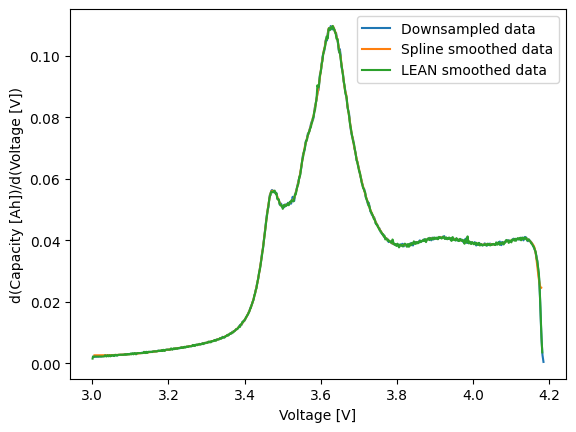

In [9]:
LEAN_dQdV = differentiation.differentiate_LEAN(
    input_data=final_cycle.discharge(0),
    x="Capacity [Ah]",
    y="Voltage [V]",
    k=10,
    gradient="dxdy",
)

fig, ax = plt.subplots()
downsampled_data_dVdQ.plot(
    x="Voltage [V]",
    y="d(Capacity [Ah])/d(Voltage [V])",
    ax=ax,
    label="Downsampled data",
)
spline_smoothed_data_dVdQ.plot(
    x="Voltage [V]",
    y="d(Capacity [Ah])/d(Voltage [V])",
    ax=ax,
    label="Spline smoothed data",
)
LEAN_dQdV.plot(
    x="Voltage [V]",
    y="d(Capacity [Ah])/d(Voltage [V])",
    ax=ax,
    label="LEAN smoothed data",
)
ax.set_ylabel("d(Capacity [Ah])/d(Voltage [V])")